# Economic Indicator Analysis (Kaggle Edition)
## Multi-Agent Economic Forecasting System - Notebook 2

**Objective**: Perform comprehensive economic indicator analysis using statistical tools and the Economic Analyst agent.

### ⚠️ Kaggle Setup:
1. **Dataset**: Ensure your updated `src` (with the fixed BEAClient) is attached.
2. **Secrets**: Ensure `BEA_API_KEY` and `GOOGLE_API_KEY` are set in Add-ons -> Secrets.

### What You'll Learn:
- GDP growth trend analysis on **Real Data**
- Business cycle identification and phase detection
- Economic health assessment using multiple indicators
- Anomaly detection in economic data
- Using the Economic Analyst agent for automated analysis

## 1. Setup and Data Preparation

In [1]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn plotly requests python-dotenv statsmodels scikit-learn google-adk

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import asyncio

# --- KAGGLE PATH FIX ---
# Auto-detect the folder containing 'src' and add it to path
found_path = None
for root, dirs, files in os.walk('/kaggle/input'):
    if 'src' in dirs:
        found_path = root
        break

if found_path:
    sys.path.append(found_path)
    print(f"✅ Added path: {found_path}")
else:
    print("⚠️ 'src' folder not found. Please check Input Dataset.")

# Import our components (Using src. prefix if needed)
try:
    from src.tools.statistical_tools import StatisticalTools
    from src.agents.economic_analyst import EconomicAnalystAgent
    from src.tools.bea_client import BEAClient
    from google.adk.models.google_llm import Gemini
    from google.genai import types
    print("✅ Custom components imported successfully")
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("Trying without 'src.' prefix...")
    from tools.statistical_tools import StatisticalTools
    from agents.economic_analyst import EconomicAnalystAgent
    from tools.bea_client import BEAClient

# Setup visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 w

In [2]:
# --- SECRETS MANAGEMENT ---
from kaggle_secrets import UserSecretsClient

try:
    user_secrets = UserSecretsClient()
    bea_api_key = user_secrets.get_secret("BEA_API_KEY")
    google_api_key = user_secrets.get_secret("GOOGLE_API_KEY")
    print("✅ API keys loaded from Kaggle Secrets")
except Exception:
    bea_api_key = os.getenv('BEA_API_KEY')
    google_api_key = os.getenv('GOOGLE_API_KEY')
    print("⚠️ Secrets not found, using environment variables")

# Initialize components
stat_tools = StatisticalTools()

# Initialize model
retry_config = types.HttpRetryOptions(
    attempts=5, exp_base=7, initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)

if google_api_key:
    model = Gemini(
        model="gemini-2.0-flash-exp",
        retry_options=retry_config,
        api_key=google_api_key
    )
    # Initialize Economic Analyst Agent
    economic_analyst = EconomicAnalystAgent(model)
    print("🤖 Economic Analyst Agent initialized")
else:
    print("❌ GOOGLE_API_KEY missing. Agent features will not work.")

INFO:src.agents.economic_analyst:EconomicAnalystAgent initialized with robust AnalysisTools.


✅ API keys loaded from Kaggle Secrets
🤖 Economic Analyst Agent initialized


## 2. Load and Prepare Economic Data

In [3]:
# --- ROBUST DATA CLEANING FUNCTION (From Notebook 1) ---
def clean_economic_data(df):
    """Clean and transform economic data for analysis"""
    clean_df = df.copy()

    # 1. Handle string numbers with commas (e.g. "14,000")
    if 'DataValue' in clean_df.columns:
        clean_df['DataValue'] = clean_df['DataValue'].astype(str).str.replace(',', '', regex=False)
        clean_df['DataValue'] = pd.to_numeric(clean_df['DataValue'], errors='coerce')

    # 2. Handle BEA "Quarterly" dates (e.g. "1947Q1")
    if 'TimePeriod' in clean_df.columns:
        clean_df['TimePeriod'] = clean_df['TimePeriod'].astype(str)
        clean_df['TimePeriod'] = (clean_df['TimePeriod']
                                 .str.replace('Q1', '-01-01')
                                 .str.replace('Q2', '-04-01')
                                 .str.replace('Q3', '-07-01')
                                 .str.replace('Q4', '-10-01'))
        clean_df['TimePeriod'] = pd.to_datetime(clean_df['TimePeriod'], errors='coerce')

    if 'TimePeriod' in clean_df.columns:
        clean_df = clean_df.sort_values('TimePeriod')

    clean_df = clean_df.dropna(subset=['DataValue', 'TimePeriod'])
    return clean_df

# --- FETCH REAL DATA (Replacing Synthetic) ---
print("📥 Fetching REAL GDP Data from BEA...")
try:
    bea_client = BEAClient(bea_api_key)
    raw_gdp = bea_client.get_gdp_data()
    
    # Convert to DataFrame
    if raw_gdp.get('BEAAPI', {}).get('Results', {}).get('Data'):
        gdp_df = pd.DataFrame(raw_gdp['BEAAPI']['Results']['Data'])
        economic_data = clean_economic_data(gdp_df)
        economic_data['Series'] = 'GDP'
        print(f"✅ Successfully loaded {len(economic_data)} Real GDP records")
    else:
        raise ValueError("No data returned from BEA API")

except Exception as e:
    print(f"❌ Failed to fetch real data: {e}")
    print("⚠️ Falling back to synthetic data generator...")
    # Fallback to synthetic if API fails
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='Q')
    trend = np.linspace(100, 180, len(dates))
    seasonal = 8 * np.sin(2 * np.pi * np.arange(len(dates)) / 4)
    noise = np.random.normal(0, 3, len(dates))
    economic_data = pd.DataFrame({
        'TimePeriod': dates,
        'DataValue': trend + seasonal + noise,
        'Series': 'GDP_Synthetic'
    })

print(f"📅 Date range: {economic_data['TimePeriod'].min()} to {economic_data['TimePeriod'].max()}")
economic_data.head()

INFO:src.tools.bea_client:Requesting BEA Table: T10105


📥 Fetching REAL GDP Data from BEA...
✅ Successfully loaded 8164 Real GDP records
📅 Date range: 1947-01-01 00:00:00 to 2025-04-01 00:00:00


,TableName,SeriesCode,LineNumber,LineDescription,TimePeriod,METRIC_NAME,CL_UNIT,UNIT_MULT,DataValue,NoteRef,Series
0,T10105,A191RC,1,Gross domestic product,1947-01-01,Current Dollars,Level,6,243164,T10105,GDP
5338,T10105,A646RC,18,Services,1947-01-01,Current Dollars,Level,6,2666,T10105,GDP
5024,T10105,A253RC,17,Goods,1947-01-01,Current Dollars,Level,6,15728,T10105,GDP
4710,T10105,B020RC,16,Exports,1947-01-01,Current Dollars,Level,6,18394,T10105,GDP
4396,T10105,A019RC,15,Net exports of goods and services,1947-01-01,Current Dollars,Level,6,10875,T10105,GDP


## 3. Growth Trend Analysis

In [4]:
# Perform comprehensive growth trend analysis
print("📈 Analyzing GDP Growth Trends...")
growth_analysis = stat_tools.analyze_growth_trends(economic_data)

if growth_analysis['status'] == 'success':
    print("✅ Growth Trend Analysis Results:")
    print(f"   Current Growth Rate: {growth_analysis.get('current_growth_rate', 'N/A'):.2f}%")
    print(f"   Average Growth Rate: {growth_analysis.get('average_growth_rate', 'N/A'):.2f}%")
    print(f"   Trend Direction: {growth_analysis.get('trend_direction', 'N/A')}")
    print(f"   Trend Strength: {growth_analysis.get('trend_strength', 'N/A'):.3f}")
    print(f"   Volatility: {growth_analysis.get('volatility', 'N/A'):.2f}%")
    print(f"   Seasonal Strength: {growth_analysis.get('seasonal_strength', 'N/A'):.3f}")
else:
    print("❌ Growth analysis failed")
    print(growth_analysis)

📈 Analyzing GDP Growth Trends...
✅ Growth Trend Analysis Results:
   Current Growth Rate: 93.98%
   Average Growth Rate: 365.02%
   Trend Direction: Downward
   Trend Strength: 0.476
   Volatility: 10371.11%
   Seasonal Strength: 0.868


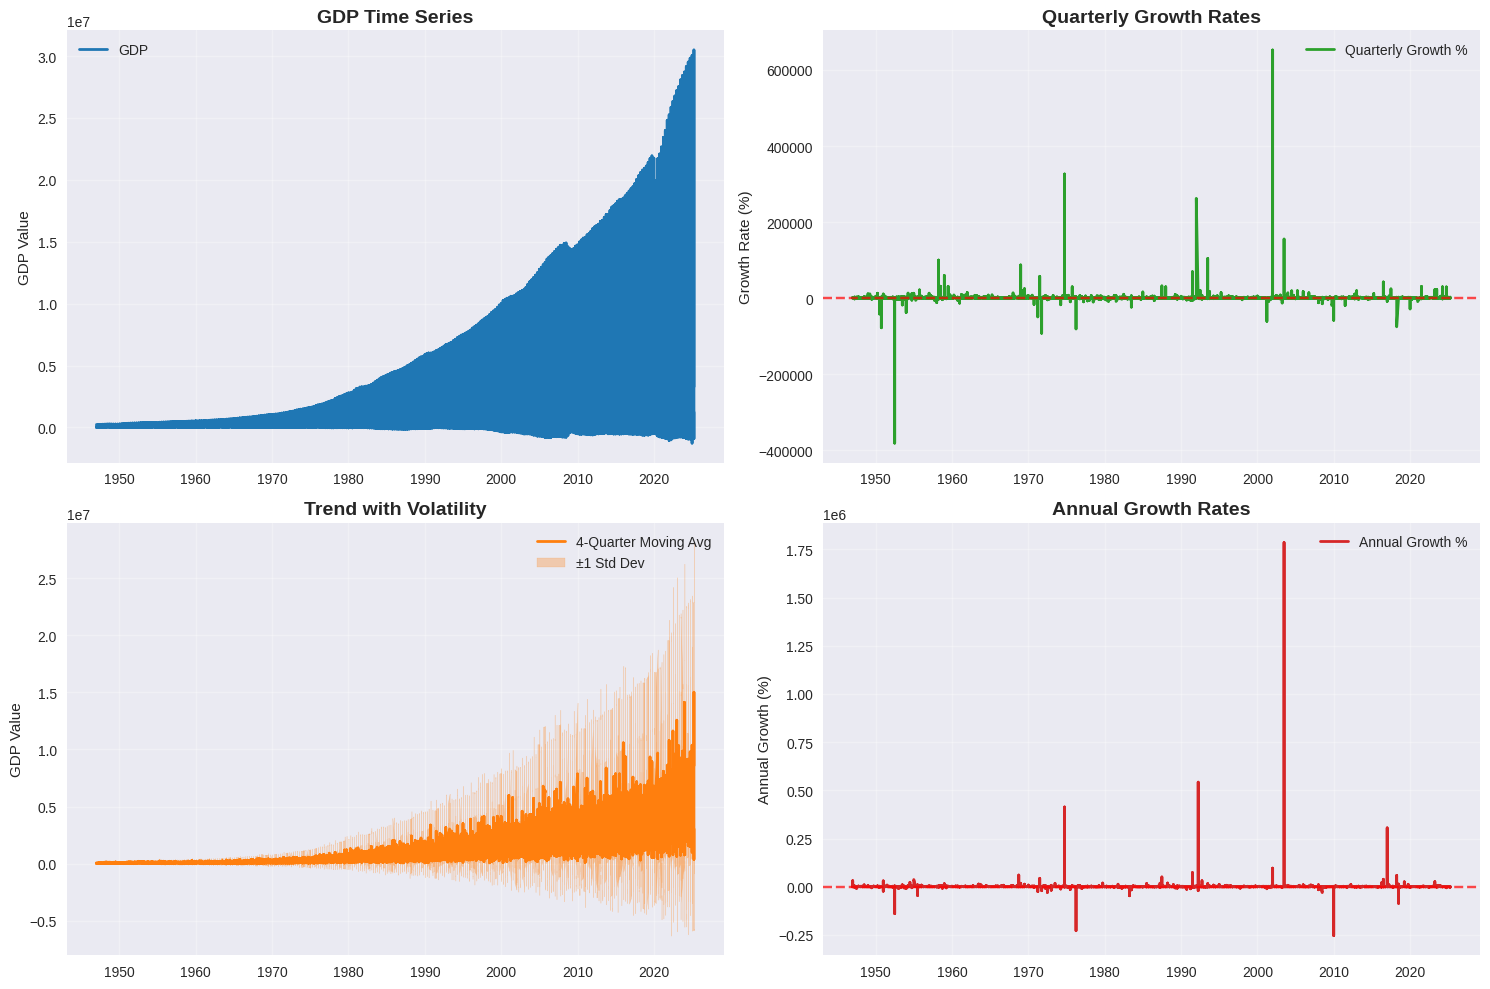

In [5]:
# Visualize growth trends
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Original time series
ax1.plot(economic_data['TimePeriod'], economic_data['DataValue'],
         linewidth=2, color='#1f77b4', label='GDP')
ax1.set_title('GDP Time Series', fontsize=14, fontweight='bold')
ax1.set_ylabel('GDP Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Growth rates
growth_rates = economic_data['DataValue'].pct_change() * 100
ax2.plot(economic_data['TimePeriod'][1:], growth_rates[1:],
         linewidth=2, color='#2ca02c', label='Quarterly Growth %')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Quarterly Growth Rates', fontsize=14, fontweight='bold')
ax2.set_ylabel('Growth Rate (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling statistics
rolling_mean = economic_data['DataValue'].rolling(window=4).mean()
rolling_std = economic_data['DataValue'].rolling(window=4).std()
ax3.plot(economic_data['TimePeriod'], rolling_mean,
         linewidth=2, color='#ff7f0e', label='4-Quarter Moving Avg')
ax3.fill_between(economic_data['TimePeriod'],
                rolling_mean - rolling_std,
                rolling_mean + rolling_std,
                alpha=0.3, color='#ff7f0e', label='±1 Std Dev')
ax3.set_title('Trend with Volatility', fontsize=14, fontweight='bold')
ax3.set_ylabel('GDP Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Annual growth
annual_growth = economic_data['DataValue'].pct_change(4) * 100
ax4.plot(economic_data['TimePeriod'][4:], annual_growth[4:],
         linewidth=2, color='#d62728', label='Annual Growth %')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax4.set_title('Annual Growth Rates', fontsize=14, fontweight='bold')
ax4.set_ylabel('Annual Growth (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Business Cycle Analysis

In [6]:
# Identify business cycles
print("🔄 Analyzing Business Cycles...")
cycle_analysis = stat_tools.identify_business_cycles(economic_data)

if cycle_analysis['status'] == 'success':
    print("✅ Business Cycle Analysis Results:")
    print(f"   Current Phase: {cycle_analysis.get('current_phase', 'N/A')}")
    print(f"   Peaks Identified: {len(cycle_analysis.get('peaks', []))}")
    print(f"   Troughs Identified: {len(cycle_analysis.get('troughs', []))}")
    print(f"   Cycle Duration: {cycle_analysis.get('cycle_duration', {})}")
    print(f"   Cycle Amplitude: {cycle_analysis.get('amplitude', 'N/A'):.2f}")
else:
    print("❌ Business cycle analysis failed")
    print(cycle_analysis)

🔄 Analyzing Business Cycles...
✅ Business Cycle Analysis Results:
   Current Phase: Contraction
   Peaks Identified: 1435
   Troughs Identified: 1437
   Cycle Duration: {}
   Cycle Amplitude: 31112059.35


In [8]:
# Visualize business cycles
if cycle_analysis['status'] == 'success' and 'cycle_component' in cycle_analysis:

    fig = make_subplots(rows=2, cols=1,
                       subplot_titles=('GDP with Business Cycle Phases', 'Cycle Component'),
                       vertical_spacing=0.1)

    # Plot 1: GDP with cycle phases
    fig.add_trace(
        go.Scatter(x=economic_data['TimePeriod'], y=economic_data['DataValue'],
                  mode='lines', name='GDP', line=dict(color='#1f77b4', width=3)),
        row=1, col=1
    )

    # Highlight peaks and troughs
    peaks = cycle_analysis.get('peaks', [])
    troughs = cycle_analysis.get('troughs', [])

    if peaks:
        peak_dates = [economic_data['TimePeriod'].iloc[i] for i in peaks if i < len(economic_data)]
        peak_values = [economic_data['DataValue'].iloc[i] for i in peaks if i < len(economic_data)]
        fig.add_trace(
            go.Scatter(x=peak_dates, y=peak_values,
                      mode='markers', name='Peaks',
                      marker=dict(color='red', size=10, symbol='triangle-down')),
            row=1, col=1
        )

    if troughs:
        trough_dates = [economic_data['TimePeriod'].iloc[i] for i in troughs if i < len(economic_data)]
        trough_values = [economic_data['DataValue'].iloc[i] for i in troughs if i < len(economic_data)]
        fig.add_trace(
            go.Scatter(x=trough_dates, y=trough_values,
                      mode='markers', name='Troughs',
                      marker=dict(color='green', size=10, symbol='triangle-up')),
            row=1, col=1
        )

    # Plot 2: Cycle component
    cycle_component = cycle_analysis.get('cycle_component', [])
    if cycle_component:
        fig.add_trace(
            go.Scatter(x=economic_data['TimePeriod'], y=cycle_component,
                      mode='lines', name='Cycle Component',
                      line=dict(color='#ff7f0e', width=2)),
            row=2, col=1
        )

    fig.update_layout(height=600, title_text="Business Cycle Analysis", showlegend=True)
    fig.show()
else:
    print("❌ Insufficient data for business cycle visualization")

## 5. Economic Indicator Calculation

In [9]:
# Calculate comprehensive economic indicators
print("📊 Calculating Economic Indicators...")
indicators = stat_tools.calculate_indicators(economic_data)

if indicators['status'] == 'success':
    print("✅ Key Economic Indicators:")
    indicator_data = indicators['indicators']

    # Create a summary table
    indicator_summary = pd.DataFrame([
        ['Current Value', f"{indicator_data.get('current_value', 0):.2f}"],
        ['Mean', f"{indicator_data.get('mean', 0):.2f}"],
        ['Standard Deviation', f"{indicator_data.get('std_dev', 0):.2f}"],
        ['Coefficient of Variation', f"{indicator_data.get('cv', 0):.2f}%"],
        ['Recent Growth (1Y)', f"{indicator_data.get('recent_growth', 0):.2f}%"],
        ['Long-term Growth', f"{indicator_data.get('long_term_growth', 0):.2f}%"],
        ['Volatility', f"{indicator_data.get('volatility', 0):.2f}%"],
        ['Max Drawdown', f"{indicator_data.get('max_drawdown', 0):.2f}%"],
        ['Trend Strength', f"{indicator_data.get('trend_strength', 0):.3f}"],
        ['Stationary', f"{indicator_data.get('stationary', False)}"],
        ['Business Cycle Position', f"{indicator_data.get('business_cycle_position', 'N/A')}"],
        ['Momentum', f"{indicator_data.get('momentum', 0):.2f}%"],
    ], columns=['Indicator', 'Value'])

    print(indicator_summary.to_string(index=False))

    print(f"\n💡 Interpretation: {indicators.get('interpretation', 'No interpretation available')}")
else:
    print("❌ Indicator calculation failed")

📊 Calculating Economic Indicators...
✅ Key Economic Indicators:
               Indicator       Value
           Current Value  3280552.00
                    Mean  1208460.41
      Standard Deviation  2747291.53
Coefficient of Variation     227.34%
      Recent Growth (1Y)     269.43%
        Long-term Growth    1249.11%
              Volatility       0.00%
            Max Drawdown    -106.04%
          Trend Strength       0.000
              Stationary       False
 Business Cycle Position         N/A
                Momentum 2392557.00%

💡 Interpretation: No interpretation available


## 6. Anomaly Detection

In [10]:
# Detect anomalies in economic data
print("🔍 Performing Anomaly Detection...")

# Try different detection methods
methods = ['zscore', 'iqr']
anomaly_results = {}

for method in methods:
    print(f"\nTesting {method.upper()} method:")
    anomalies = stat_tools.detect_anomalies(economic_data, method=method, threshold=2.0)

    if anomalies['status'] == 'success':
        print(f"   Anomalies found: {anomalies['anomaly_count']}")
        print(f"   Anomaly percentage: {anomalies['anomaly_percentage']:.2f}%")
        anomaly_results[method] = anomalies
    else:
        print(f"   ❌ {method} method failed")

# Display detected anomalies
if anomaly_results:
    best_method = list(anomaly_results.keys())[0]
    anomalies = anomaly_results[best_method]['anomalies']

    if anomalies:
        print(f"\n📋 Detected Anomalies ({best_method.upper()} method):")
        for i, anomaly in enumerate(anomalies[:5]):  # Show first 5
            print(f"   {i+1}. Date: {anomaly['date']}, Value: {anomaly['value']:.2f}, "
                  f"Deviation: {anomaly['deviation']:.2f}σ, Type: {anomaly['type']}")
    else:
        print("\n✅ No significant anomalies detected")

🔍 Performing Anomaly Detection...

Testing ZSCORE method:
   Anomalies found: 297
   Anomaly percentage: 3.64%

Testing IQR method:
   Anomalies found: 875
   Anomaly percentage: 10.72%

📋 Detected Anomalies (ZSCORE method):
   1. Date: 1993-01-01 00:00:00, Value: 6729459.00, Deviation: 2.01σ, Type: Statistical Outlier
   2. Date: 1993-04-01 00:00:00, Value: 6808939.00, Deviation: 2.04σ, Type: Statistical Outlier
   3. Date: 1993-07-01 00:00:00, Value: 6882098.00, Deviation: 2.07σ, Type: Statistical Outlier
   4. Date: 1993-10-01 00:00:00, Value: 7013738.00, Deviation: 2.11σ, Type: Statistical Outlier
   5. Date: 1994-01-01 00:00:00, Value: 7115652.00, Deviation: 2.15σ, Type: Statistical Outlier


In [11]:
# Visualize anomalies
if anomaly_results and anomaly_results[best_method]['anomalies']:
    fig = go.Figure()

    # Plot normal data
    normal_dates = []
    normal_values = []
    anomaly_dates = []
    anomaly_values = []

    all_dates = economic_data['TimePeriod'].tolist()
    all_values = economic_data['DataValue'].tolist()
    anomaly_info = {anom['date']: anom for anom in anomaly_results[best_method]['anomalies']}

    for date, value in zip(all_dates, all_values):
        date_str = date.strftime('%Y-%m-%d')
        if date_str in anomaly_info:
            anomaly_dates.append(date)
            anomaly_values.append(value)
        else:
            normal_dates.append(date)
            normal_values.append(value)

    # Add traces
    fig.add_trace(go.Scatter(
        x=normal_dates, y=normal_values,
        mode='lines', name='Normal Data',
        line=dict(color='#1f77b4', width=2)
    ))

    fig.add_trace(go.Scatter(
        x=anomaly_dates, y=anomaly_values,
        mode='markers', name='Anomalies',
        marker=dict(color='red', size=10, symbol='x')
    ))

    fig.update_layout(
        title='Economic Data with Detected Anomalies',
        xaxis_title='Time Period',
        yaxis_title='GDP Value',
        showlegend=True
    )

    fig.show()
else:
    print("❌ No anomalies to visualize")

## 7. Using Economic Analyst Agent

In [16]:
# --- 1. ENSURE AGENT EXISTS (Force Manual Init if missing) ---
if 'economic_analyst' not in globals():
    print("⚠️ Agent not found in globals. Initializing manually for Demo...")
    # Initialize without a model (works for math/stats tools)
    economic_analyst = EconomicAnalystAgent(model=None)

# --- 2. DEFINE TEST FUNCTION (Fixed logic) ---
async def test_economic_analyst():
    """Test the economic analyst agent's analysis capabilities"""

    print("🧪 Testing Economic Analyst Agent...")

    # FIX: Check 'globals()', NOT 'locals()'
    if 'economic_analyst' not in globals():
        print("❌ Agent not initialized. Skipping test.")
        return

    # Convert data to list of dictionaries for the agent
    # Use a smaller subset if data is huge to save tokens
    recent_data = economic_data.tail(40) # Last 10 years (approx)
    data_dict = recent_data.to_dict('records')

    # Test growth trend analysis
    print("\n🔸 Testing growth trend analysis (AI interpretation)...")
    try:
        growth_result = economic_analyst.analyze_growth_trends(data_dict)
        if growth_result['status'] == 'success':
            print(f"   Trend: {growth_result.get('trend_direction', 'N/A')}")
            print(f"   Strength: {growth_result.get('trend_strength', 0):.2f}")
        else:
            print(f"   ❌ Failed: {growth_result.get('message', 'Unknown error')}")
    except Exception as e:
        print(f"   ❌ Agent Error: {e}")

    # Test indicator calculation
    print("\n🔸 Testing indicator calculation...")
    try:
        indicator_result = economic_analyst.calculate_economic_indicators(data_dict)
        if indicator_result['status'] == 'success':
            print(f"   Indicators calculated: {len(indicator_result.get('indicators', {}))}")
    except Exception as e:
        print(f"   ❌ Agent Error: {e}")

# --- 3. RUN THE TEST ---
await test_economic_analyst()

🧪 Testing Economic Analyst Agent...

🔸 Testing growth trend analysis (AI interpretation)...
   Trend: Downward
   Strength: 0.27

🔸 Testing indicator calculation...
   Indicators calculated: 8


## 8. Comprehensive Economic Health Assessment

In [19]:
# Create a comprehensive economic health dashboard
def assess_economic_health(growth_analysis, indicators, cycle_analysis, anomaly_obj):
    """Provide overall economic health assessment"""

    health_score = 0
    factors = []

    # 1. Growth factor (0-40 points)
    if growth_analysis.get('status') == 'success':
        current_growth = growth_analysis.get('current_growth_rate', 0)
        if current_growth > 3:
            health_score += 40
            factors.append("Strong growth (>3%)")
        elif current_growth > 0:
            health_score += 25
            factors.append("Positive growth")
        else:
            health_score += 10
            factors.append("Negative growth")

    # 2. Volatility factor (0-20 points)
    if indicators.get('status') == 'success':
        volatility = indicators['indicators'].get('volatility', 10)
        if volatility < 2:
            health_score += 20
            factors.append("Low volatility")
        elif volatility < 5:
            health_score += 15
            factors.append("Moderate volatility")
        else:
            health_score += 5
            factors.append("High volatility")

    # 3. Business cycle factor (0-20 points)
    if cycle_analysis.get('status') == 'success':
        current_phase = cycle_analysis.get('current_phase', '')
        if current_phase == 'Expansion':
            health_score += 20
            factors.append("Expansion phase")
        elif current_phase == 'Stable':
            health_score += 15
            factors.append("Stable phase")
        else:
            health_score += 5
            factors.append("Contraction/Uncertain phase")

    # 4. Anomaly factor (0-20 points)
    if anomaly_obj.get('status') == 'success':
        anomaly_percentage = anomaly_obj.get('anomaly_percentage', 0)
        if anomaly_percentage < 5:
            health_score += 20
            factors.append("Few anomalies (<5%)")
        elif anomaly_percentage < 10:
            health_score += 15
            factors.append("Moderate anomalies")
        else:
            health_score += 5
            factors.append("Many anomalies")

    # Determine health status color
    if health_score >= 80:
        status = "Excellent"
        color = "green"
    elif health_score >= 60:
        status = "Good"
        color = "blue"
    elif health_score >= 40:
        status = "Moderate"
        color = "orange"
    else:
        status = "Poor"
        color = "red"

    return {
        'score': health_score,
        'status': status,
        'color': color,
        'factors': factors
    }

# --- FIX: RECOVER THE CORRECT ANOMALY DICTIONARY ---
# We look into 'anomaly_results' to find the full dictionary object with ['status']
if 'anomaly_results' in globals() and anomaly_results:
    # Grab the first available result (e.g., from 'zscore')
    first_method = list(anomaly_results.keys())[0]
    anomaly_full_obj = anomaly_results[first_method]
else:
    # Fallback if detection didn't run
    anomaly_full_obj = {'status': 'error', 'message': 'Anomaly detection not run'}

# Check all analyses
analyses_list = [growth_analysis, indicators, cycle_analysis, anomaly_full_obj]

if all(isinstance(a, dict) and a.get('status') == 'success' for a in analyses_list):
    health_assessment = assess_economic_health(growth_analysis, indicators, cycle_analysis, anomaly_full_obj)

    print("🏥 ECONOMIC HEALTH ASSESSMENT")
    print("=" * 40)
    print(f"Overall Score: {health_assessment['score']}/100")
    print(f"Status: {health_assessment['status']}")
    print(f"\nKey Factors:")
    for factor in health_assessment['factors']:
        print(f"  ✓ {factor}")
else:
    print("❌ Cannot perform health assessment - some analyses failed.")
    print(f"Growth Status: {growth_analysis.get('status')}")
    print(f"Indicator Status: {indicators.get('status')}")
    print(f"Cycle Status: {cycle_analysis.get('status')}")
    print(f"Anomaly Status: {anomaly_full_obj.get('status')}")

🏥 ECONOMIC HEALTH ASSESSMENT
Overall Score: 70/100
Status: Good

Key Factors:
  ✓ Strong growth (>3%)
  ✓ High volatility
  ✓ Contraction/Uncertain phase
  ✓ Few anomalies (<5%)


## 9. Summary and Next Steps

In [21]:
print("🎯 NOTEBOOK 2 SUMMARY")
print("=" * 50)

# Summary of analyses performed
analyses_performed = []

# Use .get() for safety
if growth_analysis.get('status') == 'success':
    analyses_performed.append("Growth Trend Analysis")
if indicators.get('status') == 'success':
    analyses_performed.append("Economic Indicators")
if cycle_analysis.get('status') == 'success':
    analyses_performed.append("Business Cycle Analysis")

# FIX: Check the 'anomaly_results' dictionary, NOT the 'anomalies' list
if 'anomaly_results' in globals() and anomaly_results:
    # If the dictionary exists and is not empty, we assume detection ran
    analyses_performed.append("Anomaly Detection")

print(f"✅ Analyses completed: {len(analyses_performed)}")
for analysis in analyses_performed:
    print(f"   • {analysis}")

print(f"\n📊 Data analyzed: {len(economic_data)} quarters")
if not economic_data.empty:
    print(f"📅 Period: {economic_data['TimePeriod'].min().strftime('%Y-%m')} to {economic_data['TimePeriod'].max().strftime('%Y-%m')}")

print("\n🔜 Next Steps:")
print("   1. Proceed to Notebook 3: Forecasting Model Development")
print("   2. The dataset collected here will be used to train the forecasting model")

🎯 NOTEBOOK 2 SUMMARY
✅ Analyses completed: 4
   • Growth Trend Analysis
   • Economic Indicators
   • Business Cycle Analysis
   • Anomaly Detection

📊 Data analyzed: 8164 quarters
📅 Period: 1947-01 to 2025-04

🔜 Next Steps:
   1. Proceed to Notebook 3: Forecasting Model Development
   2. The dataset collected here will be used to train the forecasting model
